In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split

### Обрабатываем данные

In [2]:
#выгружаем данные
data = pd.read_csv('../train_df.csv')
test = pd.read_csv('../test_df.csv')

In [3]:
#посмотрим что они из себя представлют
data.sample(5)

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
12364,227931,9,0,0,1,20,3,49,0,0,...,0.231500,0.094839,0.021955,0,0,0,0.03674,0.0,0.0,0
7729,288951,9,0,0,0,9,4,44,0,0,...,0.218800,0.507109,0.110955,0,0,0,0.14311,0.0,0.0,0
9765,482985,9,0,2,1,20,4,35,0,0,...,0.183426,0.606850,0.111312,0,0,0,0.56277,0.0,0.0,0
7903,310561,9,0,0,1,20,4,46,7,0,...,0.176628,0.599918,0.105962,0,0,0,0.32675,0.0,0.0,0
7649,279721,9,0,0,1,20,4,34,0,0,...,0.299609,0.748545,0.224271,0,0,0,0.99109,0.0,0.0,0


In [4]:
#заменяем не обрабатываемые символы и проверим, что лишнего не осталось
data.replace(" ", np.nan, inplace=True)
test.replace(" ", np.nan, inplace=True)

data["target"] = data.target.fillna(0).astype(float)
test["target"] = test.target.fillna(0).astype(float)

In [5]:
nan_count = data.isna().sum()
nan_count

search_id     0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_75    0
feature_76    0
feature_77    0
feature_78    0
target        0
Length: 81, dtype: int64

### Визуал

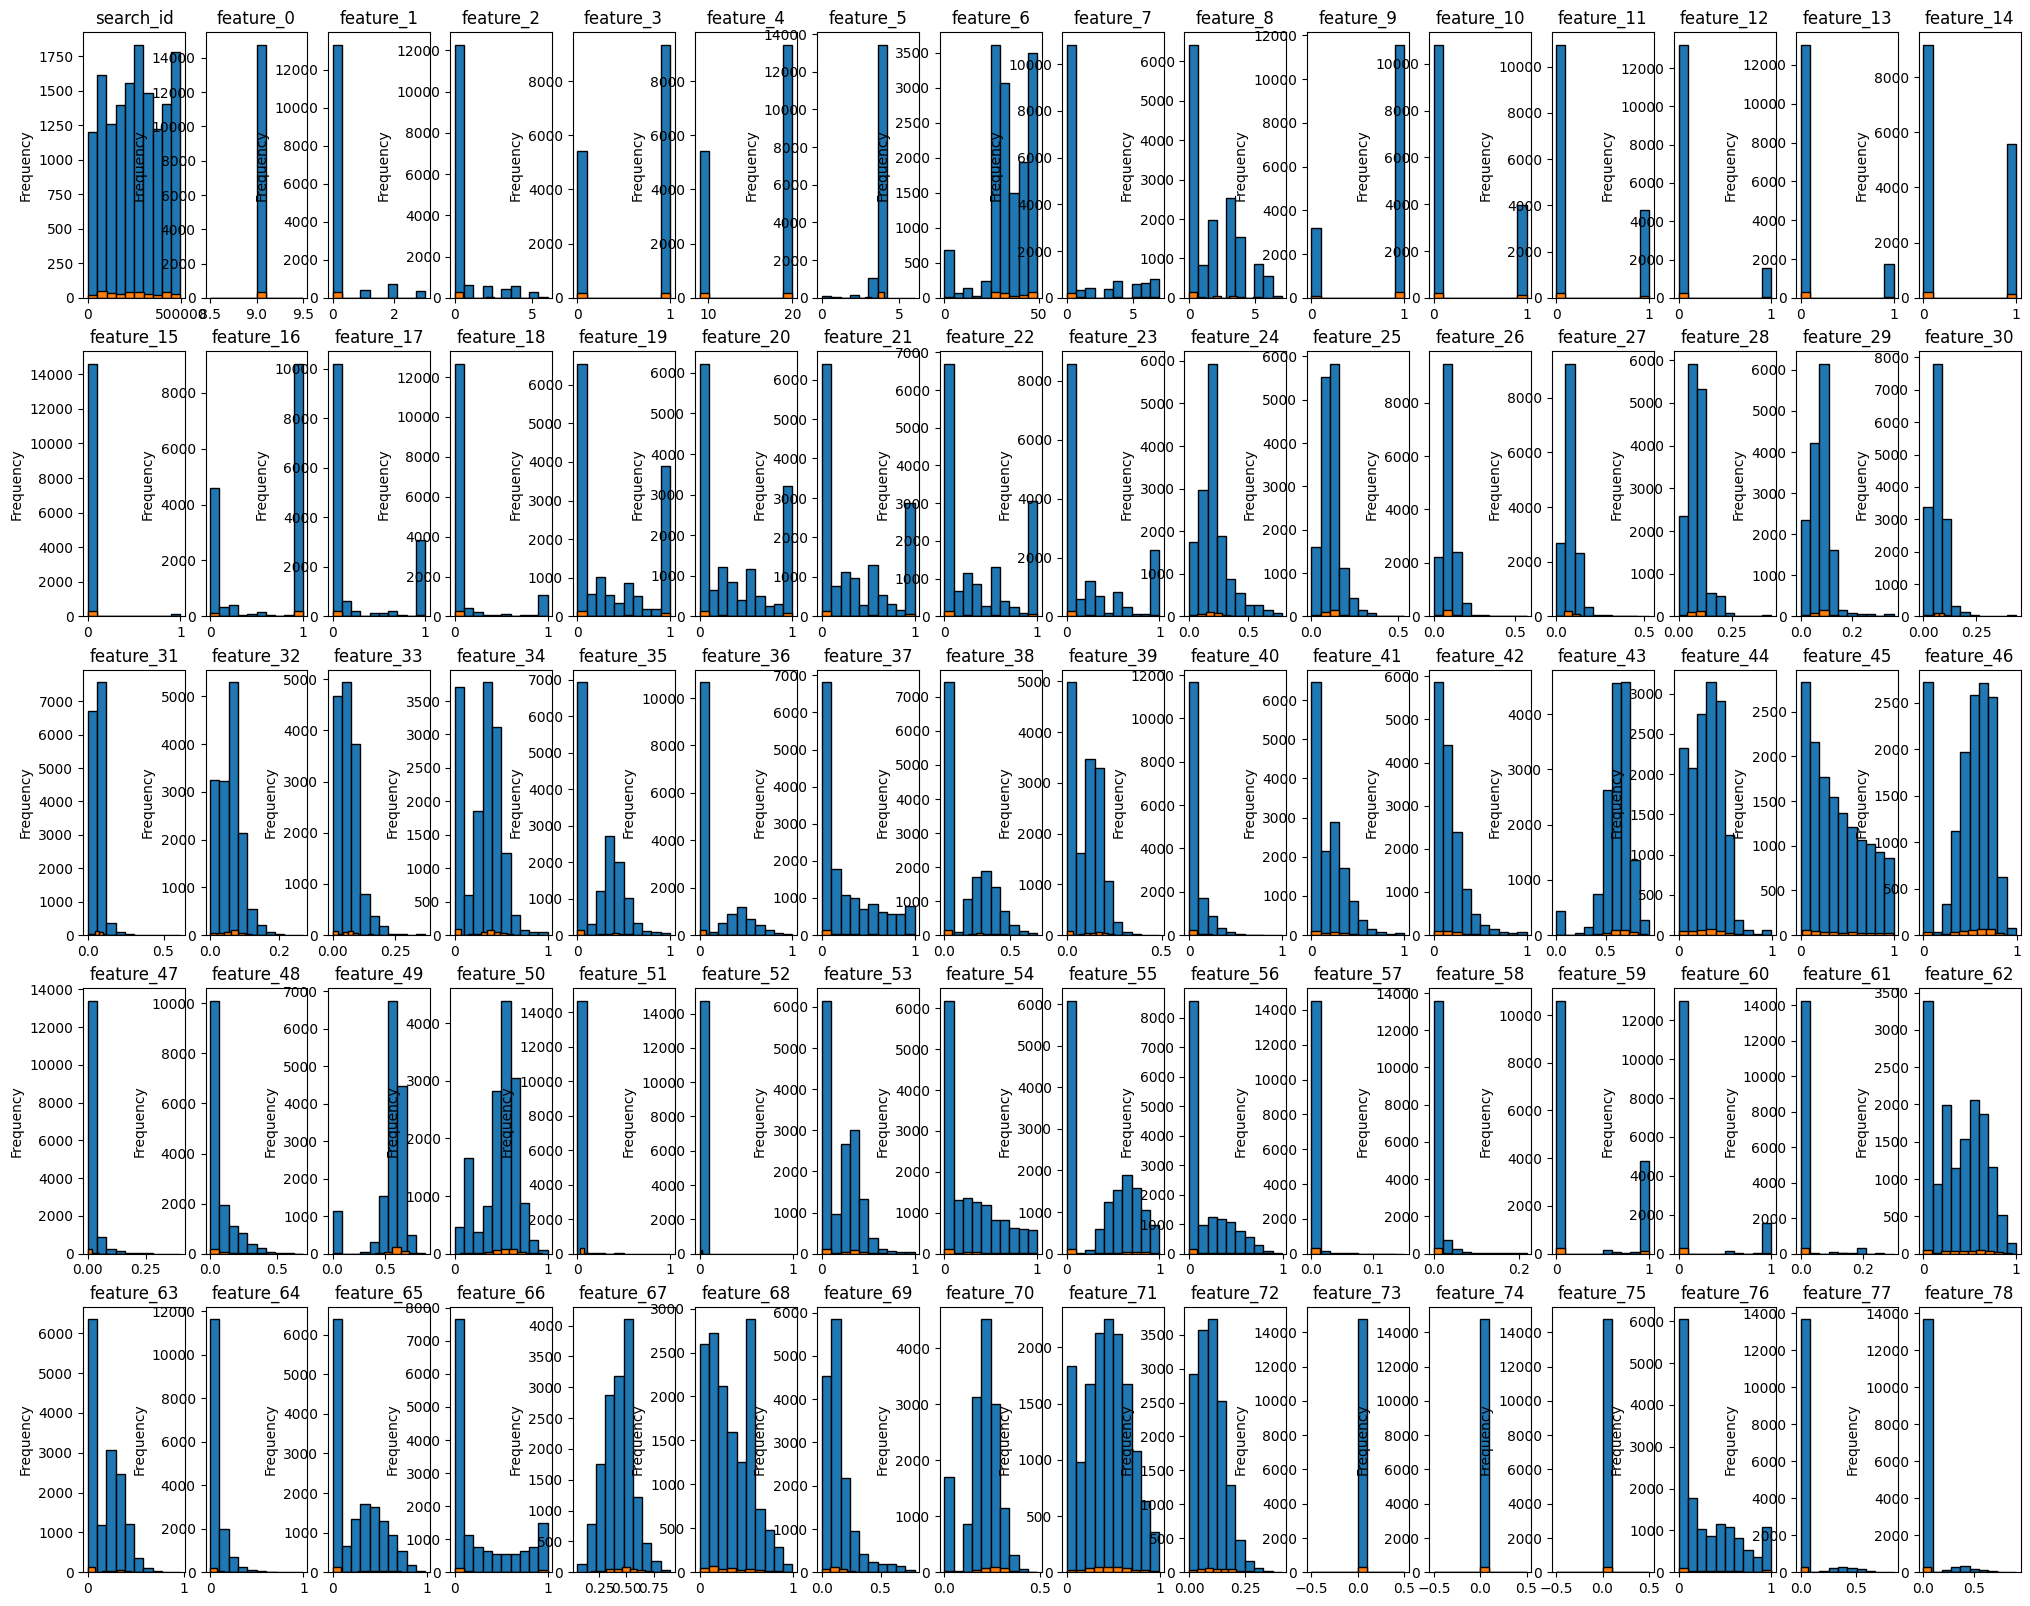

In [6]:
%matplotlib inline
fig, axes = plt.subplots(5, 16, figsize=(25, 20))
for ax, col in zip(axes.flatten(), data.columns):
    ax.set_title(col)
    data[col][data['target'] == 0].plot(kind="hist", ec="black", ax=ax)
    data[col][data['target'] == 1].plot(kind="hist", ec="black", ax=ax)

In [7]:
off_cols = ['target', 'search_id', 'feature_0', 'feature_3', 'feature_4', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_14', 'feature_73', 'feature_74', 'feature_75']
target_cols = ['target']

### Готовим данные для модели

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(columns=off_cols, axis=1).values, data[target_cols].values,
                                                       train_size=0.9,
                                                       random_state=4)
X_test, _, y_test, _ = train_test_split(test.drop(columns=off_cols, axis=1).values, test[target_cols].values,
                                                       train_size=0.99999,
                                                       random_state=41)
# X_train, y_train = data[feature_cols].drop(columns=['search_id', 'feature_0'], axis=1).values, data[target_cols].values
# X_test, y_test = test[feature_cols].drop('search_id', axis=1).values, test[target_cols].values
X_train.shape, y_train.shape

((13572, 68), (13572, 1))

### Обучаем бустинг

In [9]:
boosting_model = catboost.CatBoostClassifier(n_estimators=120)

boosting_model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

Learning rate set to 0.151785
0:	learn: 0.4524931	test: 0.4522058	best: 0.4522058 (0)	total: 52.7ms	remaining: 6.27s
1:	learn: 0.3131822	test: 0.3123686	best: 0.3123686 (1)	total: 56.9ms	remaining: 3.35s
2:	learn: 0.2317487	test: 0.2302060	best: 0.2302060 (2)	total: 60.9ms	remaining: 2.38s
3:	learn: 0.1827631	test: 0.1805115	best: 0.1805115 (3)	total: 64.6ms	remaining: 1.87s
4:	learn: 0.1530039	test: 0.1502916	best: 0.1502916 (4)	total: 68.1ms	remaining: 1.57s
5:	learn: 0.1330048	test: 0.1304020	best: 0.1304020 (5)	total: 72.3ms	remaining: 1.37s
6:	learn: 0.1203346	test: 0.1177918	best: 0.1177918 (6)	total: 75.8ms	remaining: 1.22s
7:	learn: 0.1126362	test: 0.1100016	best: 0.1100016 (7)	total: 79.3ms	remaining: 1.11s
8:	learn: 0.1074811	test: 0.1047649	best: 0.1047649 (8)	total: 83ms	remaining: 1.02s
9:	learn: 0.1037034	test: 0.1015283	best: 0.1015283 (9)	total: 87.2ms	remaining: 960ms
10:	learn: 0.1000391	test: 0.0987506	best: 0.0987506 (10)	total: 91.3ms	remaining: 904ms
11:	learn: 0.

In [10]:
y_test_predicted.shape 

(1528,)

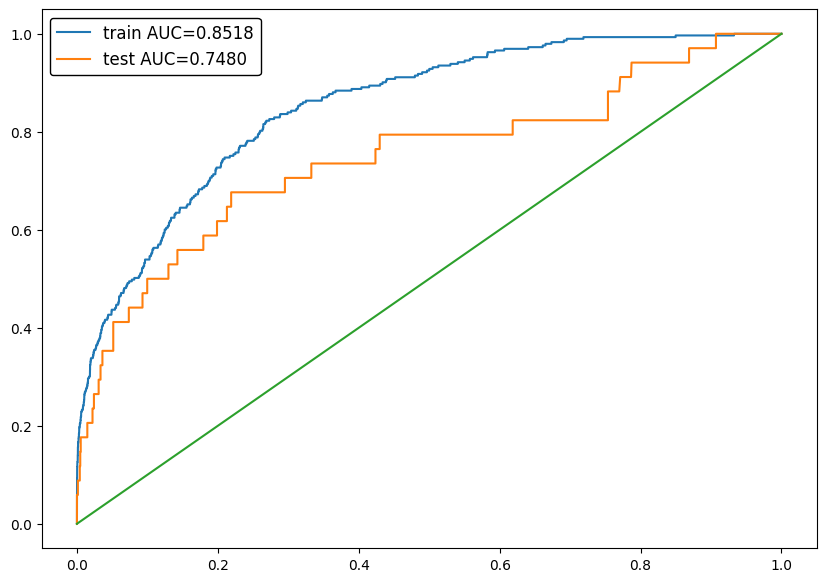

In [11]:
#визуальзируем полученные результаты
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [12]:
train_ndcg = ndcg_score(y_test.reshape(1, len(y_test)), y_test_predicted.reshape(1, len(y_test)))
train_ndcg

0.6520569818193792